In [1]:
# Importing Required Libraries.
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import keras
import os

In [2]:
piclist=[]

# Loading human images, using PIL.image to resize.

# for file in os.listdir("/kaggle/input/fire-dataset/fire_dataset/fire_images"):
for file in zip(os.listdir("/kaggle/input/human-detection-dataset/human detection dataset/1"), range(200)): # limit the number of images processed to 200
    # Resizing and converting to numpy array.
    # img=np.array(Image.open(f"/kaggle/input/fire-dataset/fire_dataset/fire_images/{file}").resize((86,48), Image.Resampling.LANCZOS))
    img=np.array(Image.open(f"/kaggle/input/human-detection-dataset/human detection dataset/1/{file[0]}").resize((86,48), Image.Resampling.LANCZOS))
    # checking if resize was successful, then appending the np array to list.
    if img.shape==(48,86,3):
        piclist.append(img)
val1 = len(piclist) 
print (val1)

# Loading non-human images, using PIL.Image and resize.
for file in zip(os.listdir("/kaggle/input/house-rooms-streets-image-dataset/kaggle_room_street_data/house_data"), range(200)):
    # Resizing and converting to numpy array.
    img=np.array(Image.open(f"/kaggle/input/house-rooms-streets-image-dataset/kaggle_room_street_data/house_data/{file[0]}").resize((86,48), Image.Resampling.LANCZOS))
    # checking if resize was successful, then appending the np array to list.
    if img.shape==(48,86,3):
        piclist.append(img)
val2 = len(piclist)
print (val2)

# stacking the individual arrays in piclist into a 3D numpy array.
TrainStack=np.stack(piclist)

184
384


In [3]:
# Creating binary labels for each image.
# 0 = non-human & 1 = human.

# labels=[[0]*751+[1]*(990-751)] #  751, 990
labels=[[0]*val1+[1]*(val2-val1)] # 518 757

# flatten the multi-dimentional array, returns a one-dimentional array.
labels=np.array(labels).flatten()

# converting the labels into one-hot encoding.
y = to_categorical(labels).astype(int)


In [4]:
# Spliting data into training & testing sets using `train_test_split` from the sklearn.model_selection module.
# X_train, X_test and y_train, ytest are the output for the training and testing data.  
X_train,X_test,y_train,y_test = train_test_split(TrainStack,y,test_size=0.3)

In [5]:
def MHA(inputs, head_size=128, num_heads=4, ff_dim=256, dropout=0.3): 
    x = keras.layers.LayerNormalization(epsilon=1e-6)(inputs) 
    x = keras.layers.MultiHeadAttention( key_dim=head_size, num_heads=num_heads, dropout=dropout )(x, x) 
    x = keras.layers.Dropout(dropout)(x) 
    return x + inputs

In [6]:
def build_model(input_shape):
    """
    Function that defines a Neural Network API, using the keras API.
    
    @input_shape: Tuple of the shape size and rgb example (48,86,3)
    Returns: Keras, Neural Network Model.
    """
    # Define input layer.
    inputs = keras.layers.Input(shape=input_shape)
    x = inputs
    # Defining the first convolutional layer: with 32 filters of size (3,3) to the input data.
    # Using the `relu` (rectified linear unit) activation function, that'll replace the negative values in the input with zero.
    # Kernel initializer specifies the layer weight, `he_uniform` is a variance sccaling initializer.
    x = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform')(x)
    # Defining the Max Pooling Layer, performs down-sampling of the input data by taking the max value from a (2, 2) window.
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    # Defining the 2nd  Convolutional layer:, applying 64 filters.
    x = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x) # Defining the 2nd Max Pooling Layer.
    # Batch Normalization layer: normalizes the activations of the previous layer by subtracting the batch mean and 
    # dividing by the batch standard deviation.
    x = keras.layers.BatchNormalization()(x)
    # Defining the 3rd Convolutional layer.
    x = keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2,2))(x) # Defining the 3rd Pax Pooling Layer.
    for _ in range(4): 
        x = MHA(x)
    # Flatten layer: This layer flattens the output of the previous layer into a 1D tensor, 
    # which is required for input to the next dense layer.
    x = keras.layers.Flatten()(x)
    # Dense layer with 128 neurons and `relu` activation: applies a dense connection to the input data
    # each neuron in the layer is connected to all the neurons in the previous later.
    x = keras.layers.Dense(128, activation="relu")(x)
    # Randomly sets 40% of neurons to zero during each forward pass to prevent overfitting.
    x = keras.layers.Dropout(0.4)(x)
    # Dense Layer with 1024 neurons and `relu` activation.
    x = keras.layers.Dense(1024, activation="relu")(x) 
    x = keras.layers.Dropout(0.4)(x) # Randomly sets 40% of neurons to zero during each forward pass to prevent overfitting.
    # Dense layer with 2 neurons and `softmax` activation: the output layer with 2 neurons corresponding 
    # to the 2 possible classes. The `softmax` activation function is used to produce a probability-like output for each class.
    x = keras.layers.Dense(2, activation="softmax")(x)
    # returns a Keras Model Instance, it consists of all the layers and the tensors connected between them allowing 
    # to be used for training and inference.
    return keras.Model(inputs, x)

In [7]:
# Training the Model.

# Defining learning rate scheduling, learning rate is multiplied by a factor of `0.96` after `100000 steps of training.
# This helps to gradually decrease the learning rate, which can make the training process smoother.
initial_learning_rate = 0.00001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

# List of Metrics that will be used by the model to evaluate its performance during the training.
# here we'll have measures such as true/false positive/negative, caterogical accuracy, precision, recall,
# area under the ROC Curve and area under the precision-recall curve.
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]



model=build_model((48,86,3)) # Build the model using the function that will define the architecture of the model.

# Callback to save the best model weights to a file named `human.h5` after each epoch.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "human.h5", save_best_only=True
)
# stop training if validation accuracy doesn't improve for `100` epochs.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", patience=100)
# model.summary()

# Compiling the model using categorical crossentropy loss, an Adam optimizer with the learning rate defined by lr_schedule,
# and the metrics defined in METRICS.
model.compile(loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=METRICS)
# The model is then trained on the training data X_train and y_train, evaluated on the validation data X_test and y_test,
# with a batch size of 10 and 100 epochs. The training process is monitored by the checkpoint_cb and early_stopping_cb callbacks.
# The training history is stored in the History variable.
History=model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=10,epochs=100,callbacks=[checkpoint_cb, early_stopping_cb],verbose=1)



Epoch 1/100


2023-03-17 10:00:38.836336: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


27/27 [==============================] - 18s 81ms/step - loss: 0.8568 - tp: 139.0000 - fp: 129.0000 - tn: 139.0000 - fn: 129.0000 - categorical_accuracy: 0.5187 - precision: 0.5187 - recall: 0.5187 - auc: 0.5227 - prc: 0.5116 - val_loss: 0.8294 - val_tp: 57.0000 - val_fp: 59.0000 - val_tn: 57.0000 - val_fn: 59.0000 - val_categorical_accuracy: 0.4914 - val_precision: 0.4914 - val_recall: 0.4914 - val_auc: 0.5175 - val_prc: 0.5437
Epoch 2/100
27/27 [==============================] - 1s 20ms/step - loss: 0.7837 - tp: 154.0000 - fp: 114.0000 - tn: 154.0000 - fn: 114.0000 - categorical_accuracy: 0.5746 - precision: 0.5746 - recall: 0.5746 - auc: 0.5827 - prc: 0.5574 - val_loss: 0.8455 - val_tp: 62.0000 - val_fp: 54.0000 - val_tn: 62.0000 - val_fn: 54.0000 - val_categorical_accuracy: 0.5345 - val_precision: 0.5345 - val_recall: 0.5345 - val_auc: 0.5878 - val_prc: 0.6068
Epoch 3/100
27/27 [==============================] - 1s 26ms/step - loss: 0.6892 - tp: 176.0000 - fp: 92.0000 - tn: 176.000

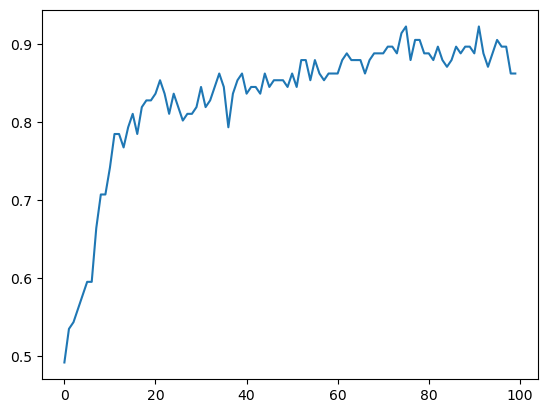

In [8]:
# plot a graph of the validation categorical accuracy over the epochs. 
# `History.history['val_categorical_accuracy'] is a list of the validation categorical accuracy at the end of each epoch.
plt.plot(History.history['val_categorical_accuracy'])

In [9]:
humanlist=['HUMAN',"NOT-HUMAN"]

CustomDict={}

# Populating the CustomDict dictionary with 25 random entries.
for _ in range(25):
    # Generating a random int between 0 and 989.
#     r=np.random.randint(0,990)
    r=np.random.randint(0,val2)

    # r- th entry in the TrainStack arrya is paired with the true Label, Human or Not-Human, and the prediction made by the model
    # when fed when fed the same image stored in the TrainStack[r].
    # The true label is obtained by finding the maximum index of the y[r] array, which is a one-hot encoded representation of the label.
    # The np.argmax function returns the index of the maximum value in the input array, which in this case corresponds to the class label.
    # The predicted label is obtained by passing np.expand_dims(TrainStack[r], axis=0) through the model using the model.predict method.
    # This results in a one-hot encoded prediction that is transformed into the class label in the same way as the true label.
    # Finally, the image, true label, and predicted label are stored in the CustomDict dictionary as a tuple. 
    CustomDict[r]=TrainStack[r],humanlist[np.argmax(y[r])],humanlist[np.argmax(model.predict(np.expand_dims(TrainStack[r],axis=0)))]

1/1 [==============================] - 0s 21ms/step


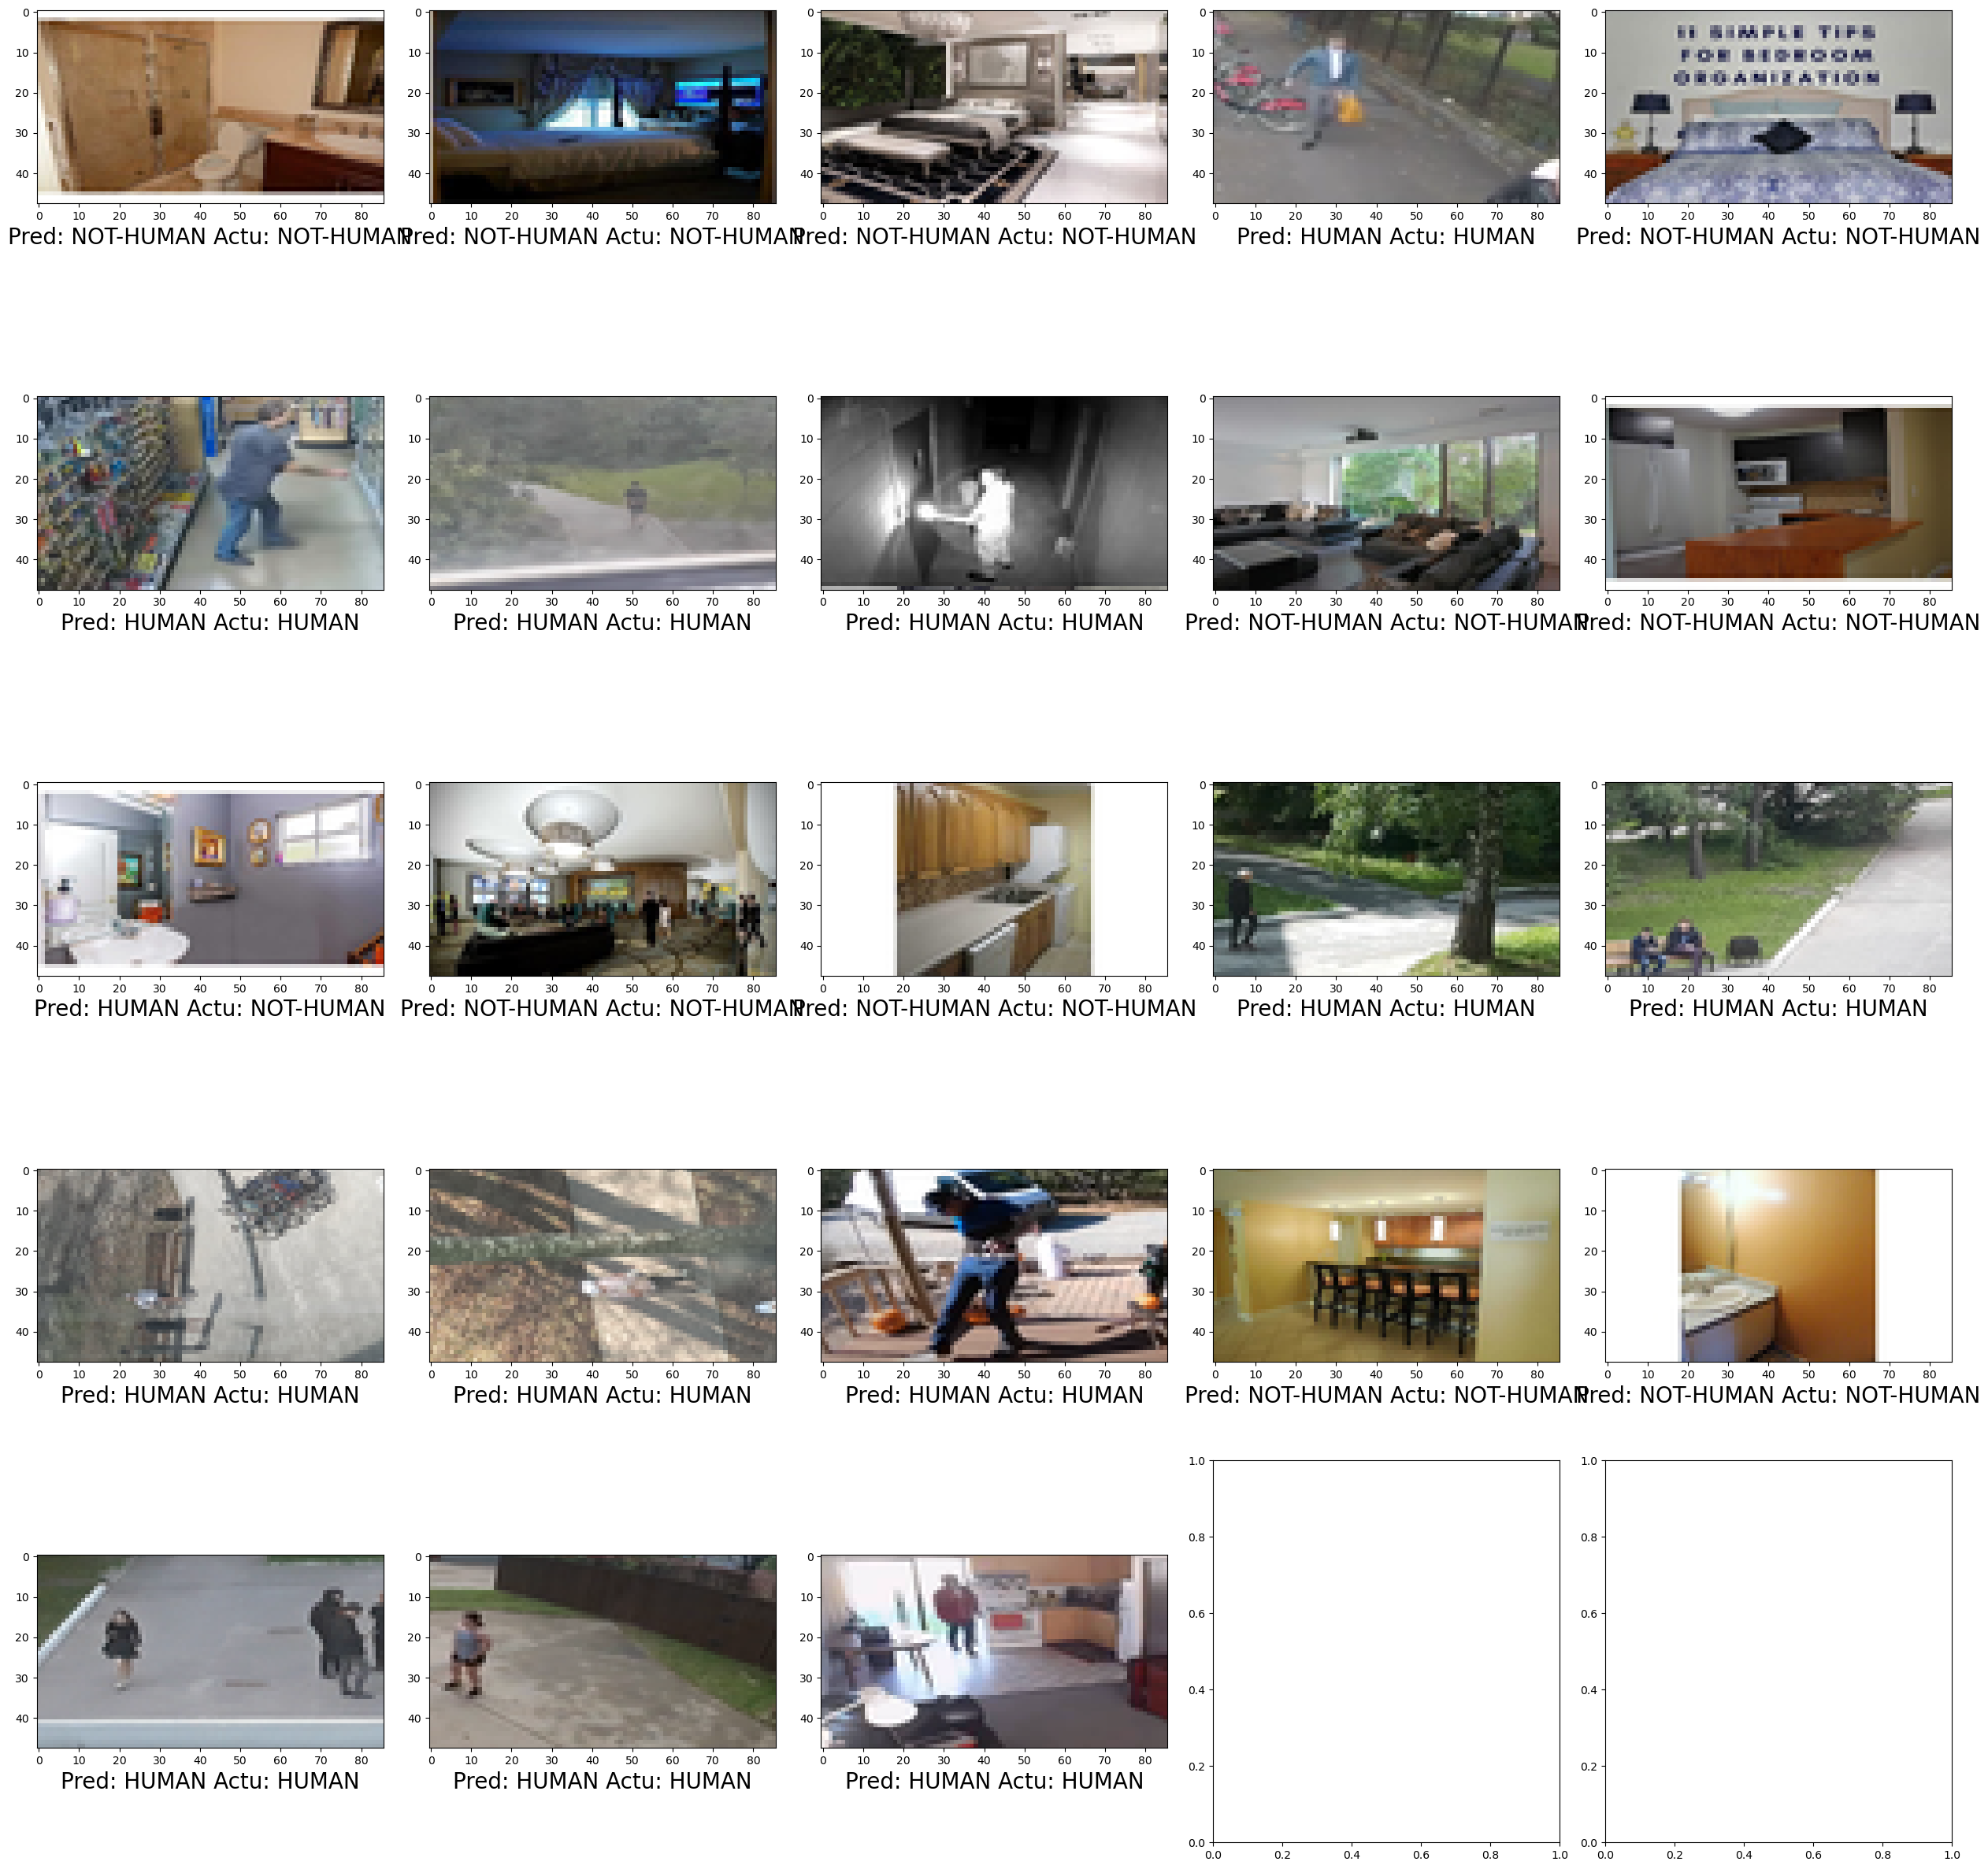

In [10]:
# Creating a 5x5 subplot figure and plots 25 randomly selected images from the TrainStack data set. 
# The actual and predicted class of each image is displayed as a label below the image.
fig, axs = plt.subplots(5,5,figsize=(25,25)) # creates a 5x5 subplot figure with a figure size of 25x25. axs is an array of subplots.
# loops over the first 25 elements of CustomDict, getting the key of the element in CustomDict and the marker == index of the element.
for key,marker in zip(CustomDict,range(25)):
    # plots the image stored in the first element of CustomDict[key] on the current subplot specified by axs[marker//5,marker%5]
    axs[marker//5,marker%5].imshow(CustomDict[key][0])
    # sets the x label of the current subplot to a string that includes both the actual and predicted class of the image. 
    # The actual class is stored in the second element of the value of CustomDict[key] and the predicted class is stored in the third element. 
    # The fontsize is set to 20.
    axs[marker//5,marker%5].set_xlabel("Pred: "+str(CustomDict[key][2]+' Actu: '+str(CustomDict[key][1])),fontsize = 20.0)
    

fig.tight_layout() # automatically adjusts the subplots so that they fit nicely within the figure.

plt.savefig(f"Human.jpg") # saves the figure to a JPEG image file named "Human.jpg